### Task: use the stellar theoretical models calculated for different ages (isochrones), in order to derive the cluster age and/or distance
* The models we use are PARSEC-COLIBRI: http://stev.oapd.inaf.it/cgi-bin/cmd_3.3
* The file contains many columns, which not all are imporant for us, but it should be straightforward to recognize those that we need (remove the "#" of the row with the keys: "Zini     MH   logAge Mini        int_IMF...").
* For simplicity, we will assume that there is no exticton towards any of our clusters, but remember that normally the extinction is yet another free parameter in the fit


In [ ]:
#at the beginning we import the necessary packages
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.table import Table
from scipy import interpolate
from shapely.geometry import LineString, Point
from astropy.stats import sigma_clipped_stats

### Reading and plotting the data

In [ ]:
#Load your data (a table with magnitudes in g,B,r)
data = Table.read('Blanco1_selected.fits', format='fits')
print(len(data))
data = data[np.isfinite(data['phot_g_mean_mag']) & np.isfinite(data['phot_bp_mean_mag']) & np.isfinite(data['phot_rp_mean_mag'])]
print(len(data))
print(data.columns)
#You can select a table column as data['column_name'], for example data['ra']
print(data['ra','dec','parallax'])

573
570
<TableColumns names=('source_id','ra','dec','parallax','parallax_error','pmra','pmra_error','pmdec','pmdec_error','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp','dr2_radial_velocity','dr2_radial_velocity_error')>
        ra                 dec              parallax     
       deg                 deg                mas        
------------------ ------------------- ------------------
 358.4550465677945 -27.569360192083632  4.213742780784015
 359.3634570919215 -27.693084237435023  4.125127385119123
 359.1361064852146  -27.75981645633663  4.270982110665523
359.64567393378474 -27.252309306939562  4.251443586163605
 357.5699015868836 -27.500029390587184  4.444376708795607
3.3136987634269564 -26.024430331622973  4.168009480464676
359.13179796792986 -28.105799712518017  4.135768869399479
  359.253456448449  -27.92326011897625 4.3211793800271865
 359.0479794215357  -27.82975898030745  4.000115687326174
 1.647044742813673  -32.80173548914716  4.442073242181564
        

Text(0, 0.5, 'G')

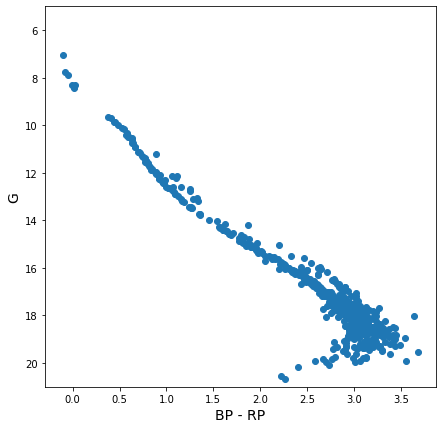

In [ ]:
#Plot color-magnitude diagram
fig = plt.figure(figsize=(7,7))
plt.scatter(data['bp_rp'],data['phot_g_mean_mag']) # x can be also  data['phot_bp_mean_mag']-data['phot_rp_mean_mag']
plt.ylim(21,5)
plt.xlabel('BP - RP',fontsize=14)
plt.ylabel('G',fontsize=14)


### Reading and plotting the models (isochrones)

In [ ]:
#Read the models
#Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
#Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('parsec_10Myr_1Gyr_step25Myr.dat', format='ascii')
print(isochrones.columns)

#Let's see which ages we have in the model file
logages=np.unique(isochrones['logAge']) #find the unique age entries
ages=np.unique(10**isochrones['logAge']/1e6) #in Myrs
for logage, age in zip(logages,ages): print(logage,age) #print all of that

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','period2','period3','period4','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag')>
7.0 10.0
7.09691 12.499999625598054
7.17609 14.999956513820402
7.24304 17.50007862882901
7.30103 20.000000199681043
7.35218 22.499869541650266
7.39794 24.9999995007974
7.43933 27.499829424260362
7.47712 29.999913327161497
7.51188 32.49974848542795
7.54407 35.00015760710141
7.57403 37.4998905357492
7.60206 40.00000079872417
7.62839 42.50010470526256
7.65321 44.99973953258027
7.67669 47.499605206891204
7.69897 49.9999995007974
7.72016 52.50008420833815
7.74036 54.99965939764019
7.75967 57.500285360875914
7.77815 59.999827253364394
7.79588 62.49999750398704
7.81291 64.99949761981426
7.8293 67.4994136121949
7.8451 70.00031591308975
7.86034 72.50033277865747
7.87506 74.99978182030029
7.8893 77.49969618775764
7.90309 80.00000239617252

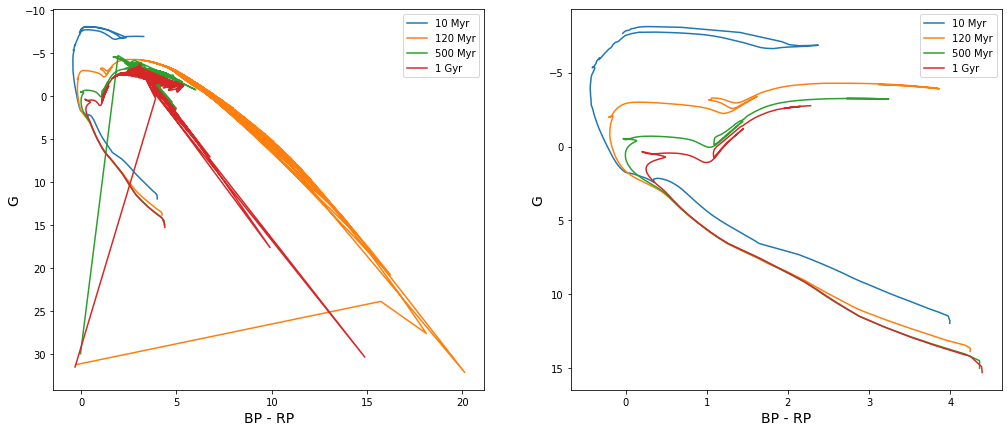

In [ ]:
#you can select the isochrone with some particular age
age_1 = isochrones['logAge'] == 7 # 10 Myrs; False where not this age, True where yes
age_2 = isochrones['logAge'] == 8.07918 # 120 Myrs
age_3 = isochrones['logAge'] == 8.69897 # 500 Myrs
age_4 = isochrones['logAge'] == 9 # 1 Gyrs

fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(17,7))
ax1.plot(isochrones['G_BPmag'][age_1] - isochrones['G_RPmag'][age_1], isochrones['Gmag'][age_1],label='10 Myr')
ax1.plot(isochrones['G_BPmag'][age_2] - isochrones['G_RPmag'][age_2], isochrones['Gmag'][age_2],label='120 Myr')
ax1.plot(isochrones['G_BPmag'][age_3] - isochrones['G_RPmag'][age_3], isochrones['Gmag'][age_3],label='500 Myr')
ax1.plot(isochrones['G_BPmag'][age_4] - isochrones['G_RPmag'][age_4], isochrones['Gmag'][age_4],label='1 Gyr')
ax1.invert_yaxis()
ax1.set_xlabel('BP - RP',fontsize=14)
ax1.set_ylabel('G',fontsize=14)
ax1.legend()

#We can cut off the more evolved stages
N=250
ax2.plot(isochrones['G_BPmag'][age_1][0:N] - isochrones['G_RPmag'][age_1][0:N], isochrones['Gmag'][age_1][0:N],label='10 Myr')
ax2.plot(isochrones['G_BPmag'][age_2][0:N] - isochrones['G_RPmag'][age_2][0:N], isochrones['Gmag'][age_2][0:N],label='120 Myr')
ax2.plot(isochrones['G_BPmag'][age_3][0:N] - isochrones['G_RPmag'][age_3][0:N], isochrones['Gmag'][age_3][0:N],label='500 Myr')
ax2.plot(isochrones['G_BPmag'][age_4][0:N] - isochrones['G_RPmag'][age_4][0:N], isochrones['Gmag'][age_4][0:N],label='1 Gyr')
ax2.invert_yaxis()
ax2.set_xlabel('BP - RP',fontsize=14)
ax2.set_ylabel('G',fontsize=14)
ax2.legend()


### Plot the data & the models together

distance modulus: 6.870311990868167
236.62596503983667


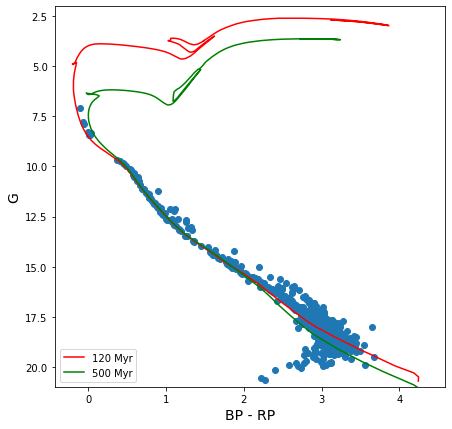

In [ ]:
#Let's now plot a model on top of our data, just approximately
fig = plt.figure(figsize=(7,7))
plt.scatter(data['bp_rp'],data['phot_g_mean_mag']) # x can be also  data['phot_bp_mean_mag']-data['phot_rp_mean_mag']
plt.ylim(21,2)
plt.xlabel('BP - RP',fontsize=14)
plt.ylabel('G',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
median_parallax=np.nanmedian(data['parallax'])
dist=1000/median_parallax #Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
DM=5*np.log10(dist)-5 #distance modulus
print('distance modulus:',DM)
plt.plot(isochrones['G_BPmag'][age_2][0:N] - isochrones['G_RPmag'][age_2][0:N], isochrones['Gmag'][age_2][0:N] + DM,label='120 Myr',color='red')
plt.plot(isochrones['G_BPmag'][age_3][0:N] - isochrones['G_RPmag'][age_3][0:N], isochrones['Gmag'][age_3][0:N] + DM,label='500 Myr',color='green')
plt.legend()
print(dist)

### Fit the isochrones to the data
* We'll do a simple manual fit by minimizing the RMSD (Root-Mean-Square Deviation)
* The free parameters in this example are the age and the distance
* To obtan a more reliable fit, you could "clean" you cluster sequence a bit, for example cutting of the very bottom whch is noisy, or remove the binary sequence in open clusters. It can be done for example in Topcat by the polygon selection.

0.15029155903920913 (33, 4)
*** Best fit model: age =  92.0 Myr; distance= 240 pc


Text(0, 0.5, 'age in Myr')

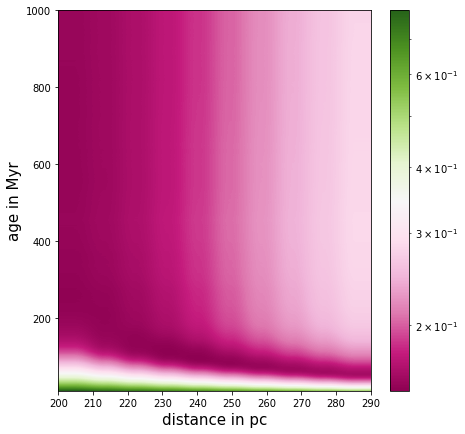

In [ ]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])

#distance
dmin,dmax,step=200,300,10
distances = np.arange(dmin,dmax,step)

#define an array to save the root-mean-square deviation values
rmsd=np.zeros(shape=(len(ages),len(distances)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(distances)):

        ## model
        distance=distances[j]
        DM=5*np.log10(distance)-5 #distance modulus
        isochrone=isochrones[isochrones['logAge'] == age][0:N]
        col_iso = isochrone['G_BPmag'] - isochrone['G_RPmag'] #color isochrone
        mag_iso = isochrone['Gmag'] + DM #magnitude isochrone, shifted to the distance of the cluster
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        ## data
        d=np.empty(len(data))
        for k in range(len(data)):
            col_data=data['bp_rp'][k]
            mag_data=data['phot_g_mean_mag'][k]
            point=Point(col_data,mag_data)
            d[k] = point.distance(line) #shortest distance of the point to the line of the isochrone
        rmsd[i,j]=np.sqrt(np.nanmean(d)**2)

fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[distances[0],distances[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance=',distances[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=distances[minrmsd_pos[1]]
plt.xlabel('distance in pc',fontsize=15)
plt.ylabel('age in Myr',fontsize=15)

distance modulus: 6.90105620855803


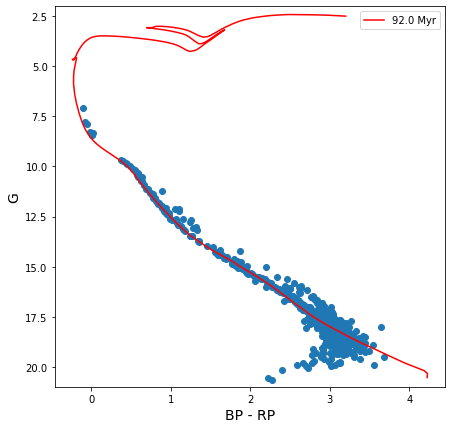

In [ ]:
#Let's now plot the best-fit model on top of our data
fig = plt.figure(figsize=(7,7))
plt.scatter(data['bp_rp'],data['phot_g_mean_mag']) # x can be also  data['phot_bp_mean_mag']-data['phot_rp_mean_mag']
plt.ylim(21,2)
plt.xlabel('BP - RP',fontsize=14)
plt.ylabel('G',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
median_parallax=np.nanmedian(data['parallax'])
DM=5*np.log10(best_dist)-5 #distance modulus
print('distance modulus:',DM)
age_1 = isochrones['logAge'] == best_age
plt.plot(isochrones['G_BPmag'][age_1][0:N] - isochrones['G_RPmag'][age_1][0:N], isochrones['Gmag'][age_1][0:N] + DM,label=str(np.round(10**best_age/1e6))+' Myr',color='red')
plt.legend()

* In the literature we find: DM=6.876 log(age)=8.06 => dist=237 pc and age=115 Myr. Our result is not bad at all, given the simplistic selection method and the fitting procedure.

## Now for a globular cluster 47 Tucanae
* from a quick search in Google, I find that the distance is ~4.5 kpc, and the age ~13 Gyrs
* I used metallicity Z=0.0056 (found in the literature)

In [ ]:
#Load the data (the table with the selected cluster members from Topcat)
data = Table.read('47Tuc_selected.fits', format='fits')
print(len(data))
data = data[np.isfinite(data['phot_g_mean_mag']) & np.isfinite(data['phot_bp_mean_mag']) & np.isfinite(data['phot_rp_mean_mag'])]


91721


In [ ]:
#Read the models
#Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
#Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('parsec_1Gyr_14Gyr_step100Myr_lowmet.dat', format='ascii')
print(isochrones.columns)
N=150
#Let's see which ages we have in the model file
logages=np.unique(isochrones['logAge']) #find the unique age entries
ages=np.unique(10**isochrones['logAge']/1e9) #in Gyrs
for logage, age in zip(logages,ages): print(logage,age) #print all of that

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','period2','period3','period4','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag')>
9.0 1.0
9.04139 1.099993198935193
9.07918 1.1999965570481133
9.11394 1.2999899653754527
9.14613 1.4000063322395284
9.17609 1.4999956513820403
9.20412 1.6000000638979344
9.23045 1.7000042221563632
9.25527 1.7999896172455905
9.27875 1.8999842462147347
9.30103 2.000000019968108
9.32222 2.1000034102666123
9.34242 2.1999864198351693
9.36173 2.300011460361904
9.38021 2.399993138057888
9.39794 2.49999995007974
9.41497 2.599979956709246
9.43136 2.699976598401209
9.44716 2.8000126924345348
9.4624 2.900013369054073
9.47712 2.9999913327161436
9.49136 3.0999879094111864
9.50515 3.2000001597448433
9.51851 3.299970062852284
9.53148 3.400008478258595
9.54407 3.500015760710141
9.5563 3.5999792704335687
9.5682 3.699985311728588
9.57978 3.7999685

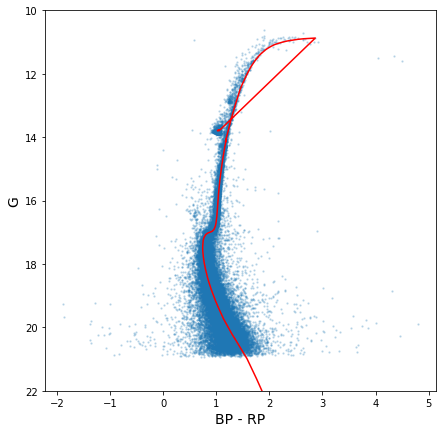

In [ ]:
#Plot color-magnitude diagram
fig = plt.figure(figsize=(7,7))
#alpha keyword is for transparency (0=completely transparent, 1=non-transparent)
plt.scatter(data['bp_rp'],data['phot_g_mean_mag'],s=2,alpha=0.2) # x can be also  data['phot_bp_mean_mag']-data['phot_rp_mean_mag']
plt.ylim(22,10)
plt.xlabel('BP - RP',fontsize=14)
plt.ylabel('G',fontsize=14)

age_1 = isochrones['logAge'] == 10.11394
distance=4500 #in pc
DM=5*np.log10(distance)-5
plt.plot(isochrones['G_BPmag'][age_1][0:N] - isochrones['G_RPmag'][age_1][0:N], isochrones['Gmag'][age_1][0:N] + DM,label='13 Gyr',color='red')

* In 47 Tuc cluster, there are orders of magnitude more potential members than in Blanco 1. This means that the code for finding the best fit becomes extremey slow...
* This may happen to any of your clusters.
* We have to try a different approach. I give you two options down here, but please feel free to improve any of them.

### Approach 1 - creating a 2D histogram out of our CMD
* Take the value of the histogram as a weight for the rmsd. The bin with more points has more weight in the calculation.

(Text(0.5, 0, 'BP-RP'), Text(0, 0.5, 'G'))

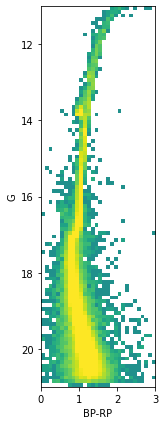

In [ ]:
bin_size = 0.1
min_edge_x,max_edge_x = 0 , 3
min_edge_y,max_edge_y = 11 , 21
bin_num_x = (max_edge_x-min_edge_x)/bin_size
bin_num_y = (max_edge_y-min_edge_y)/bin_size
bins_x = np.linspace(min_edge_x,max_edge_x,bin_num_x+1)
bins_y = np.linspace(min_edge_y,max_edge_y,bin_num_y+1)

col_data=data['bp_rp']
mag_data=data['phot_g_mean_mag']

h2d,xedges,yedges = np.histogram2d(mag_data,col_data,bins=(bins_y,bins_x))
fig,ax = plt.subplots(figsize=(7, 7))
ax.imshow(h2d, norm=LogNorm(vmin=0.01, vmax=100),extent=[min_edge_x,max_edge_x,min_edge_y,max_edge_y],origin='lower')
ax.invert_yaxis()
#ax.scatter(col_data,mag_data,s=1,c='k',alpha=0.05)
plt.xlabel('BP-RP'),plt.ylabel('G')


In [ ]:
#bins_x and bins_y are the edegs of the histogram bins
print(bins_x,bins_y)
print(bins_x.shape,bins_y.shape)
print(h2d.shape)
x=(bins_x+bin_size/2)[0:-1]
print(x)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3. ] [11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3
 12.4 12.5 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7
 13.8 13.9 14.  14.1 14.2 14.3 14.4 14.5 14.6 14.7 14.8 14.9 15.  15.1
 15.2 15.3 15.4 15.5 15.6 15.7 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5
 16.6 16.7 16.8 16.9 17.  17.1 17.2 17.3 17.4 17.5 17.6 17.7 17.8 17.9
 18.  18.1 18.2 18.3 18.4 18.5 18.6 18.7 18.8 18.9 19.  19.1 19.2 19.3
 19.4 19.5 19.6 19.7 19.8 19.9 20.  20.1 20.2 20.3 20.4 20.5 20.6 20.7
 20.8 20.9 21. ]
(31,) (101,)
(100, 30)
[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35
 1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95]


0.07988813029529321 (28, 3)
*** Best fit model: age =  12800.0 Myr; distance= 4600 pc


Text(0, 0.5, 'age in Myr')

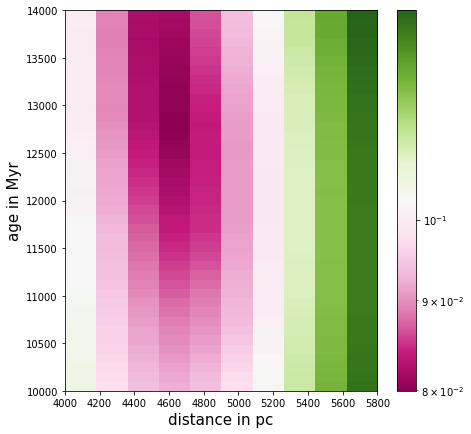

In [ ]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])
ages=ages[ages >= 10]

#distance in pc
dmin,dmax,step=4000,6000,200
distances = np.arange(dmin,dmax,step)

#values of the histogram for the fitting
x=(bins_x+bin_size/2)[0:-1] #colors
y=(bins_y+bin_size/2)[0:-1] #magnitudes
weight=h2d

#define an array to save the root-mean-square deviation values
rmsd=np.zeros(shape=(len(ages),len(distances)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(distances)):
        distance=distances[j]
        DM=5*np.log10(distance)-5 #distance modulus
        isochrone=isochrones[isochrones['logAge'] == age][0:N]
        col_iso = isochrone['G_BPmag'] - isochrone['G_RPmag'] #color isochrone
        mag_iso = isochrone['Gmag'] + DM #magnitude isochrone, shifted to the distance of the cluster
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        d=np.empty(len(x)*len(y))
        w=np.empty(len(x)*len(y))
        count=0
        for k_x in range(len(x)):
            for k_y in range(len(y)):
                col_data=x[k_x]
                mag_data=y[k_y]

                point=Point(col_data,mag_data)
                d[count] = point.distance(line) #shortest distance of the point to the isochrone
                w[count] = weight[k_y,k_x]
                count=count+1

        rmsd[i,j]=np.sqrt(np.average(d,weights=w)**2)

fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[distances[0],distances[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance=',distances[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=distances[minrmsd_pos[1]]
plt.xlabel('distance in pc',fontsize=15)
plt.ylabel('age in Myr',fontsize=15)

distance modulus: 13.313789158407868


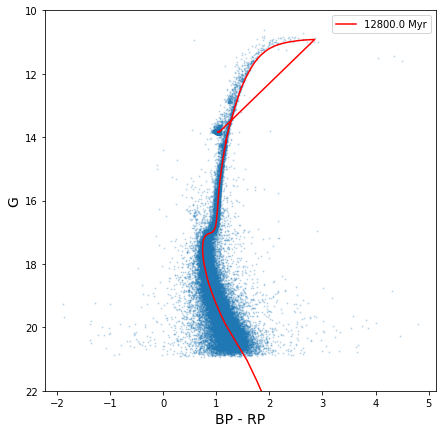

In [ ]:
#Let's now plot the best-fit model on top of our data
fig = plt.figure(figsize=(7,7))
plt.scatter(data['bp_rp'],data['phot_g_mean_mag'],alpha=0.2,s=1) # x can be also  data['phot_bp_mean_mag']-data['phot_rp_mean_mag']
plt.ylim(22,10)
plt.xlabel('BP - RP',fontsize=14)
plt.ylabel('G',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
median_parallax=np.nanmedian(data['parallax'])
DM=5*np.log10(best_dist)-5 #distance modulus
print('distance modulus:',DM)
age_1 = isochrones['logAge'] == best_age
plt.plot(isochrones['G_BPmag'][age_1][0:N] - isochrones['G_RPmag'][age_1][0:N], isochrones['Gmag'][age_1][0:N] + DM,label=str(np.round(10**best_age/1e6))+' Myr',color='red')
plt.legend()

### Approach 2 - defining the so-called "fiducial points"
* Bin the data along the y axis

<ErrorbarContainer object of 3 artists>

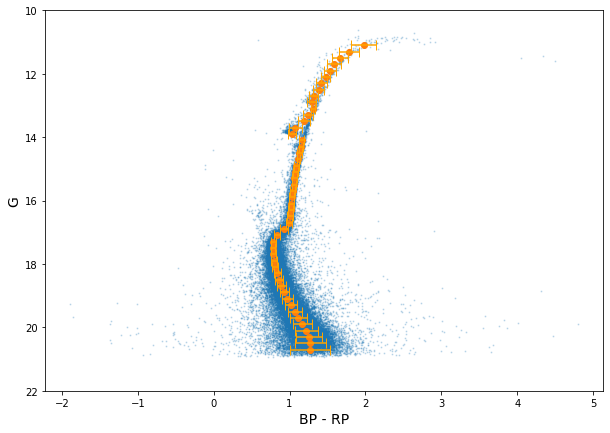

In [ ]:
#To be able to fit the model to the data, we wil first bin the data
#to some predefined grid in magnitude.
mmin, mmax, step = 11, 21, 0.2 #magnitude range we want to consider
x = np.arange(mmin, mmax, step) #magnitude axis
mags=np.zeros(len(x)-1)
cols=np.zeros(len(x)-1)
d_cols=np.zeros(len(x)-1)
for i in range(len(x)-1):
    ind=np.argwhere((data['phot_g_mean_mag'] >= x[i]) & (data['phot_g_mean_mag'] < x[i+1]))
    yy=data['bp_rp'][ind]
    mean, median, std = sigma_clipped_stats(yy, sigma=3.0)
    cols[i]=mean
    #If there is only one point per bin, we can't calculate the standard deviation
    #In that case just set some larger value, so that the point doesn't have an influence on the fit
    if std !=0: d_cols[i]=std
    else: d_cols[i]=0.5
    mags[i]=np.mean([x[i],x[i+1]])
fig = plt.figure(figsize=(10,7))
plt.scatter(data['bp_rp'],data['phot_g_mean_mag'],alpha=0.2,s=1) # x can be also  data['phot_bp_mean_mag']-data['phot_rp_mean_mag']
plt.ylim(22,10)
plt.xlabel('BP - RP',fontsize=14)
plt.ylabel('G',fontsize=14)
plt.scatter(cols,mags,label='cluster binned')
plt.errorbar(cols,mags,yerr=None,xerr=d_cols,capsize=5,color='orange',ls='none')

0.03568563777149693 (111, 4)
*** Best fit model: age =  12100.0 Myr; distance= 4400 pc


Text(0, 0.5, 'age in Myr')

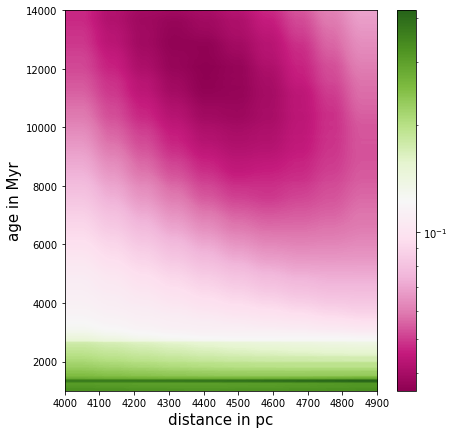

In [ ]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])

#distance
dmin,dmax,step=4000,5000,100
distances = np.arange(dmin,dmax,step)

#define an array to save the rmsd
rmsd=np.zeros(shape=(len(ages),len(distances)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(distances)):
        distance=distances[j]
        DM=5*np.log10(distance)-5 #distance modulus
        isochrone=isochrones[isochrones['logAge'] == age][0:N]
        col_iso = isochrone['G_BPmag'] - isochrone['G_RPmag'] #color isochrone
        mag_iso = isochrone['Gmag'] + DM #magnitude isochrone, shifted to the distance of the cluster
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        d=np.empty(len(cols))
        for k in range(len(cols)):
            col_data=cols[k]
            mag_data=mags[k]
            point=Point(col_data,mag_data)
            d[k] = point.distance(line) #shortest distance of the point to the isochrone

        rmsd[i,j]=np.sqrt(np.nanmean(d)**2)

fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[distances[0],distances[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance=',distances[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=distances[minrmsd_pos[1]]
plt.xlabel('distance in pc',fontsize=15)
plt.ylabel('age in Myr',fontsize=15)


distance modulus: 13.217263382430936


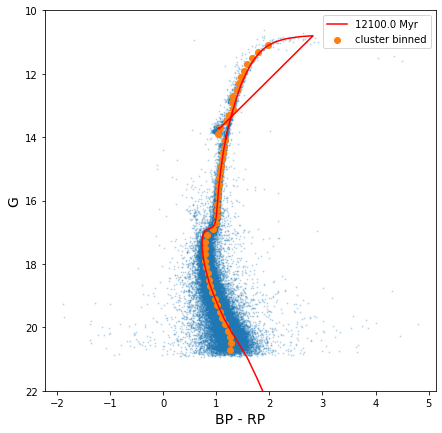

In [ ]:
#Let's now plot the best-fit model on top of our data
fig = plt.figure(figsize=(7,7))
plt.scatter(data['bp_rp'],data['phot_g_mean_mag'],alpha=0.2,s=1) # x can be also  data['phot_bp_mean_mag']-data['phot_rp_mean_mag']
plt.ylim(22,10)
plt.xlabel('BP - RP',fontsize=14)
plt.ylabel('G',fontsize=14)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
median_parallax=np.nanmedian(data['parallax'])
DM=5*np.log10(best_dist)-5 #distance modulus
print('distance modulus:',DM)
age_1 = isochrones['logAge'] == best_age
plt.plot(isochrones['G_BPmag'][age_1][0:N] - isochrones['G_RPmag'][age_1][0:N], isochrones['Gmag'][age_1][0:N] + DM,label=str(np.round(10**best_age/1e6))+' Myr',color='red')
plt.scatter(cols,mags,label='cluster binned')
plt.legend()